# Part 2: Random Forest Classifier

In [1]:
import numpy as np
import pandas as pd
import csv
from collections import Counter
from sklearn.datasets import make_classification
#from imblearn.over_sampling import SMOTE, ADASYN


df = pd.read_csv('DF.csv')
df.columns

Index(['Unnamed: 0', 'RD_NO', 'WEATHER_CONDITION', 'INJURIES_TOTAL', 'DAMAGE',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'CRASH_HOUR', 'LIGHTING_CONDITION',
       'MANEUVER', 'TRAFFICWAY_TYPE', 'PRIM_CONTRIBUTORY_CAUSE',
       'POSTED_SPEED_LIMIT', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'INJURIES_PER_PASSENGER', 'DANGER_SCORE', 'COMBINED_DANGER_SCORE'],
      dtype='object')

In [4]:
df= df.loc[:,[ 'WEATHER_CONDITION',
       'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'CRASH_HOUR', 'LIGHTING_CONDITION',
       'MANEUVER', 'TRAFFICWAY_TYPE', 'PRIM_CONTRIBUTORY_CAUSE',
       'POSTED_SPEED_LIMIT','COMBINED_DANGER_SCORE']]

df.head()
df_test_interest = df

### 1. Using Upsampling/Downsampling to Handle Imbalanced Dataset

In [5]:
# Approach 1: Upsampling or known as oversampling

## do RANDOM SAMPLING TO PICK EQUAL NUMBER OF DATA IN EACH Y GROUP
# down sampling
df4=df.reset_index()
X=df4.drop(columns = 'COMBINED_DANGER_SCORE')
y=df4.COMBINED_DANGER_SCORE

# find the number of levels in y and number of entries associated with each level

unique_levels = np.unique(y)
unique_counts = {level: sum(y == level) for level in unique_levels}
print(unique_counts)

# find the target number of data points
import operator
unique_counts.items()
max_level = max(unique_counts.items(), key=operator.itemgetter(1))[0]
min_level = min(unique_counts.items(), key=operator.itemgetter(1))[0]
target_number = unique_counts[max_level]
target_number_min = unique_counts[min_level]

# find which data points are associated with which group

grouped_levels = {}
for ii, level in enumerate(unique_levels):
    obs_idx = [idx for idx, val in enumerate(y) if val == level]
    grouped_levels[level] = obs_idx

grouped_levels

#oversampling
sampled_levels={}
from random import choices
# sample indices
for i in list(unique_levels):
    if i != max_level:
        sampled_levels[i] = choices(grouped_levels[i], k=target_number )
    else:
        sampled_levels[i] = grouped_levels[i]

first = df4.iloc[sampled_levels[1]].reset_index()
second = df4.iloc[sampled_levels[2]].reset_index()
third = df4.iloc[sampled_levels[3]].reset_index()

new_oversampled = pd.concat([first,second,third], axis = 0)
new_oversampled = new_oversampled.drop(columns = ['level_0','index'])




{1.0: 153383, 2.0: 180741, 3.0: 29925}


In [4]:

# Approach 2: Downsampling 

sampled_levels={}
from random import choices
# sample indices
for i in list(unique_levels):
    if i != min_level:
        sampled_levels[i] = choices(grouped_levels[i], k=target_number_min )
    else:
        sampled_levels[i] = grouped_levels[i]

first = df4.iloc[sampled_levels[1]].reset_index()
second = df4.iloc[sampled_levels[2]].reset_index()
third = df4.iloc[sampled_levels[3]].reset_index()

new_downsampled = pd.concat([first,second,third], axis = 0)
new_downsampled = new_downsampled.drop(columns = ['level_0','index'])

In [6]:
df_train_interest = new_oversampled

### 2. Dummy Binary Variables and Train-Test Preparation

We have to convert categorical variables to categories for one-hot encoding.


In [7]:
# Define the lambda function: categorize_label
# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')
labels = ['WEATHER_CONDITION', 'CRASH_DAY_OF_WEEK','LIGHTING_CONDITION','MANEUVER', 'TRAFFICWAY_TYPE', 'PRIM_CONTRIBUTORY_CAUSE']
# Convert df[LABELS] to a categorical type
#df_train_interest[labels] = df_train_interest[labels].astype('category')
print(df_train_interest[labels].dtypes)

WEATHER_CONDITION          object
CRASH_DAY_OF_WEEK           int64
LIGHTING_CONDITION         object
MANEUVER                   object
TRAFFICWAY_TYPE            object
PRIM_CONTRIBUTORY_CAUSE    object
dtype: object


In [8]:
df_train_interest = pd.get_dummies(df_train_interest, drop_first = True)
df_test_interest = pd.get_dummies(df_test_interest, drop_first = True)


In [9]:
from sklearn.model_selection import train_test_split
train_df1, test_df1 = train_test_split(df_train_interest, test_size=0.2, random_state=100)
train_df2, test_df2 = train_test_split(df_test_interest, test_size=0.2, random_state=100)

X_train = train_df1.drop(columns = 'COMBINED_DANGER_SCORE')
Y_train = train_df1.COMBINED_DANGER_SCORE
X_test  = test_df2.drop(columns = 'COMBINED_DANGER_SCORE')
Y_test = test_df2.COMBINED_DANGER_SCORE



### 3. Determining Out-of-Bag (OOB) Loss Against Number of Estimators in Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

trees = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
oob_loss = []
test_scores = []

for i in trees:
    print('calculating for trees =', i)
    classifier = RandomForestClassifier(n_estimators = i, criterion = 'entropy', oob_score = True)
    classifier.fit(X_train, Y_train)


    oob_loss.append(1-classifier.oob_score_)
    test_scores.append(classifier.score(X_test,Y_test))


calculating for trees = 5


D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


calculating for trees = 10


D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


calculating for trees = 20


D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


calculating for trees = 30


D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


calculating for trees = 40
calculating for trees = 50
calculating for trees = 60
calculating for trees = 70
calculating for trees = 80
calculating for trees = 90
calculating for trees = 100


In [19]:
classifier = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', oob_score = True)
classifier.fit(X_train, Y_train)

one_tree_oob = 1-classifier.oob_score_

D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:453: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
D:\Users\Jonathan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [26]:
oob_losses = [one_tree_oob] + oob_loss

Text(0.5,1,'OOB Loss Against Number of Trees')

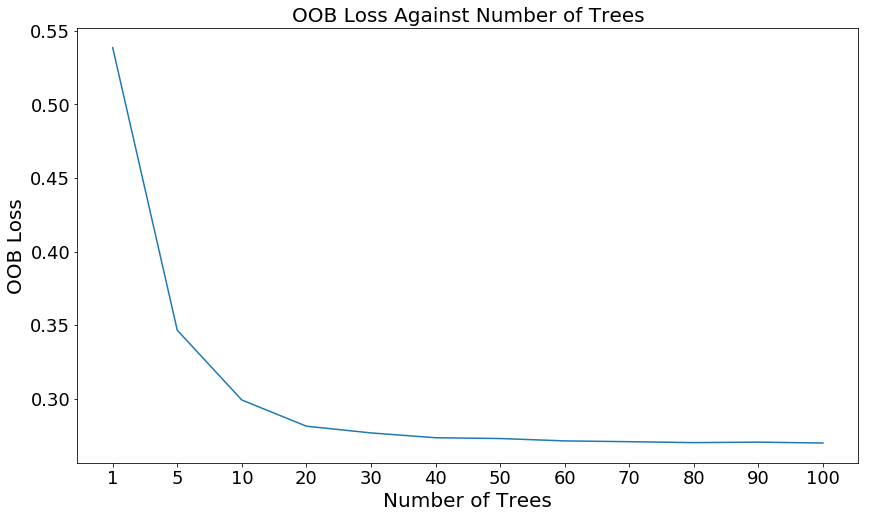

In [35]:
import matplotlib.pyplot as plt

no_trees = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

fig, ax = plt.subplots(figsize = (14,8))

plt.plot(oob_losses)

x = [i for i in range(len(no_trees))]
plt.xticks(x, no_trees)
plt.tick_params(labelsize=18)
ax.set_xlabel('Number of Trees', fontsize = 20)
ax.set_ylabel('OOB Loss', fontsize = 20)
ax.set_title('OOB Loss Against Number of Trees', fontsize = 20)

### 4. Optimizing Random Forest Classifier Parameters Using K-cross Validation

In [62]:
from sklearn.model_selection import cross_val_score

n_estimators = [10,20,30,40,50,60,70,80,90,100]
max_depth = [50,60,70,80,90,100,None]
# Usually, min_samples_split = 2 and min_samples_leaf = 1 give the best results. 
k = 5

opt_estimators = 0
opt_depth = 0
best_score = 0
all_scores = []

for n_est in n_estimators:
    print('Training for n_estimators = ', n_est)
    for depth in max_depth:
        print('... for max_depth = ', depth)
        clf = RandomForestClassifier(n_estimators = n_est, max_depth = depth,\
                                    min_samples_split = 2, min_samples_leaf = 1)
        k_score = np.mean(cross_val_score(clf, X_train, Y_train, cv = k))
        all_scores.append(k_score)

        if k_score > best_score:
            opt_estimators = n_est
            opt_depth = depth
            best_score = k_score

Training for n_estimators =  10
... for max_depth =  50
... for max_depth =  60
... for max_depth =  70
... for max_depth =  80
... for max_depth =  90
... for max_depth =  100
... for max_depth =  None
Training for n_estimators =  20
... for max_depth =  50
... for max_depth =  60
... for max_depth =  70
... for max_depth =  80
... for max_depth =  90
... for max_depth =  100
... for max_depth =  None
Training for n_estimators =  30
... for max_depth =  50
... for max_depth =  60
... for max_depth =  70
... for max_depth =  80
... for max_depth =  90
... for max_depth =  100
... for max_depth =  None
Training for n_estimators =  40
... for max_depth =  50
... for max_depth =  60
... for max_depth =  70
... for max_depth =  80
... for max_depth =  90
... for max_depth =  100
... for max_depth =  None
Training for n_estimators =  50
... for max_depth =  50
... for max_depth =  60
... for max_depth =  70
... for max_depth =  80
... for max_depth =  90
... for max_depth =  100
... for max

In [65]:
print(opt_estimators)
print(opt_depth)
print(best_score)
print(np.asarray(all_scores).reshape(10,7))

100
60
0.7139181798629457
[[0.70439026 0.70468535 0.70523401 0.7049689  0.70545993 0.70504959
  0.70501962]
 [0.71002218 0.70949425 0.71002448 0.71034722 0.71044405 0.70950809
  0.70999451]
 [0.71167509 0.7112417  0.71166357 0.71196326 0.71149298 0.71190793
  0.7114169 ]
 [0.71262489 0.71289922 0.71201167 0.71265486 0.71278857 0.71260184
  0.71210389]
 [0.71343175 0.71296839 0.71333032 0.71282315 0.71304446 0.71273324
  0.71222837]
 [0.71328652 0.71337873 0.71307213 0.71302371 0.71386516 0.71290844
  0.71310209]
 [0.71326577 0.71287386 0.71361618 0.7133234  0.71259954 0.71338565
  0.71319892]
 [0.71328422 0.71341331 0.71358852 0.71376141 0.71340409 0.71330957
  0.7132335 ]
 [0.71333724 0.71378908 0.71357239 0.71344097 0.71364154 0.71367381
  0.71383749]
 [0.71345481 0.71391818 0.7134502  0.71369226 0.71349631 0.71354933
  0.71342023]]


In [66]:
opt_clf = RandomForestClassifier(n_estimators = opt_estimators, max_depth = opt_depth, min_samples_split = 2,\
                            min_samples_leaf = 1)
opt_clf.fit(X_train, Y_train)
print('Score with optimized parameters:', opt_clf.score(X_test, Y_test))

Score with optimized parameters: 0.7401455843977476


In [67]:
ConfusionMatrix = pd.DataFrame(confusion_matrix(Y_test,opt_clf.predict(X_test)), columns = ['Predicted 1', 'Predicted 2','Predicted 3'], index = ['Actual 1', 'Actual 2','Actual 3'])
print(ConfusionMatrix)

          Predicted 1  Predicted 2  Predicted 3
Actual 1        21107         6519         3197
Actual 2         4964        27264         3832
Actual 3          196          212         5519


### 5. Gini Importance of Features

In [68]:
feature_impt = pd.DataFrame(opt_clf.feature_importances_, index = X_train.columns, columns = ['importance'])
feature_impt.sort_values(by = 'importance',ascending = False)

,importance
CRASH_HOUR,0.273147
CRASH_MONTH,0.243401
CRASH_DAY_OF_WEEK,0.175532
POSTED_SPEED_LIMIT,0.067039
WEATHER_CONDITION_RAIN,0.018068
PRIM_CONTRIBUTORY_CAUSE_unknown,0.013744
LIGHTING_CONDITION_DAYLIGHT,0.009969
WEATHER_CONDITION_SNOW,0.009463
WEATHER_CONDITION_CLOUDY/OVERCAST,0.009365
TRAFFICWAY_TYPE_NOT DIVIDED,0.009222


In [11]:
#Approach 3: SMOTE
categorize_label = lambda x: x.astype('category')
labels = ['WEATHER_CONDITION', 'CRASH_DAY_OF_WEEK','LIGHTING_CONDITION','MANEUVER', 'TRAFFICWAY_TYPE', 'PRIM_CONTRIBUTORY_CAUSE']
# Convert df[LABELS] to a categorical type
df[labels] = df[labels].astype('category')
df = pd.get_dummies(df, drop_first = True)


train_df1, test_df1 = train_test_split(df, test_size=0.2, random_state=100)
X_train_SMOTE = train_df1.drop(columns = 'COMBINED_DANGER_SCORE')
Y_train_SMOTE = train_df1.COMBINED_DANGER_SCORE
X_test_SMOTE = test_df1.drop(columns = 'COMBINED_DANGER_SCORE')
Y_test_SMOTE = test_df1.COMBINED_DANGER_SCORE

X_resampled_SMOTE, Y_resampled_SMOTE = SMOTE().fit_sample(X_train_SMOTE, Y_train_SMOTE)
print(sorted(Counter(Y_resampled_SMOTE).items()))


LogisticRegressionModel.fit(X_resampled_SMOTE,Y_resampled_SMOTE)
print(LogisticRegressionModel.score(X_test,Y_test))

Y_true_SMOTE = Y_test_SMOTE
Y_pred_SMOTE = LogisticRegressionModel.predict(X_test_SMOTE)
ConfusionMatrix = pd.DataFrame(confusion_matrix(Y_true_SMOTE,Y_pred_SMOTE), columns = ['Predicted 1', 'Predicted 2','Predicted 3'], index = ['Actual 1', 'Actual 2','Actual 3'])
print(ConfusionMatrix)


# random forest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
classifier.fit(X_train_SMOTE, Y_train_SMOTE)
Y_pred_forest = classifier.predict(X_test_SMOTE)
Y_true_forest = Y_test_SMOTE


print(classifier.score(X_test_SMOTE,Y_test_SMOTE))

ConfusionMatrix = pd.DataFrame(confusion_matrix(Y_true_forest,Y_pred_forest), columns = ['Predicted 1', 'Predicted 2','Predicted 3'], index = ['Actual 1', 'Actual 2','Actual 3'])
print(ConfusionMatrix)




[(1, 144681), (2, 144681), (3, 144681)]
0.35144897678890263
          Predicted 1  Predicted 2  Predicted 3
Actual 1        14524         5228        11071
Actual 2        12778         7102        16180
Actual 3         1161          803         3963
0.5650185414091471
          Predicted 1  Predicted 2  Predicted 3
Actual 1        17376        12612          835
Actual 2        12558        22345         1157
Actual 3         1718         2791         1418


In [12]:
# Approach 4: ADASYN

# sm = ADASYN()
# X_resampled_ADASYN, Y_resampled_ADASYN = sm.fit_sample(X_train, Y_train)
# print(sorted(Counter(Y_resampled_ADASYN).items()))


# LogisticRegressionModel.fit(X_resampled_ADASYN,Y_resampled_ADASYN)
# print(LogisticRegressionModel.score(X_test,Y_test))

# Y_true = Y_test
# Y_pred = LogisticRegressionModel.predict(X_test)
# ConfusionMatrix = pd.DataFrame(confusion_matrix(Y_true,Y_pred), columns = ['Predicted 1', 'Predicted 2','Predicted 3'], index = ['Actual 1', 'Actual 2','Actual 3'])
# ConfusionMatrix


In [13]:
# random forest
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
classifier.fit(X_train, Y_train)
Y_pred_forest = classifier.predict(X_test)
Y_true_forest = Y_test


print(classifier.score(X_test,Y_test))

ConfusionMatrix = pd.DataFrame(confusion_matrix(Y_true_forest,Y_pred_forest), columns = ['Predicted 1', 'Predicted 2','Predicted 3'], index = ['Actual 1', 'Actual 2','Actual 3'])
ConfusionMatrix


0.7352973492652108


,Predicted 1,Predicted 2,Predicted 3
Actual 1,21340,6201,3282
Actual 2,5438,26689,3933
Actual 3,221,198,5508
